# Lesson 8.04 Time Series II (Solution Code)

## Advanced Time Series Analysis

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import itertools

We are going to do time series analysis and forecasting for furniture sales.

In [2]:
df = pd.read_excel("data/superstore-sales.xls")
furniture = df.loc[df['Category'] == 'Furniture']

We have a good 4-year furniture sales data. 

In [3]:
furniture['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [4]:
furniture['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [5]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [6]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [7]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [8]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


## Indexing with time series data

In [9]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [10]:
# change the time interval of data set from daily to monthly
# 'MS' refers to Month Start which will be used as the new timestamp value
y = furniture['Sales'].resample('MS').mean()

Have a quick peek 2017 sales data.

In [11]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Visualizing furniture sales time series data

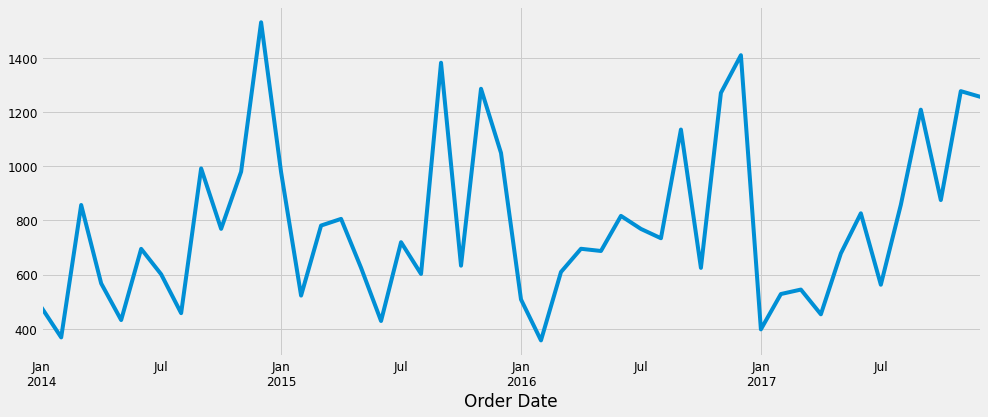

In [12]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always a strong upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

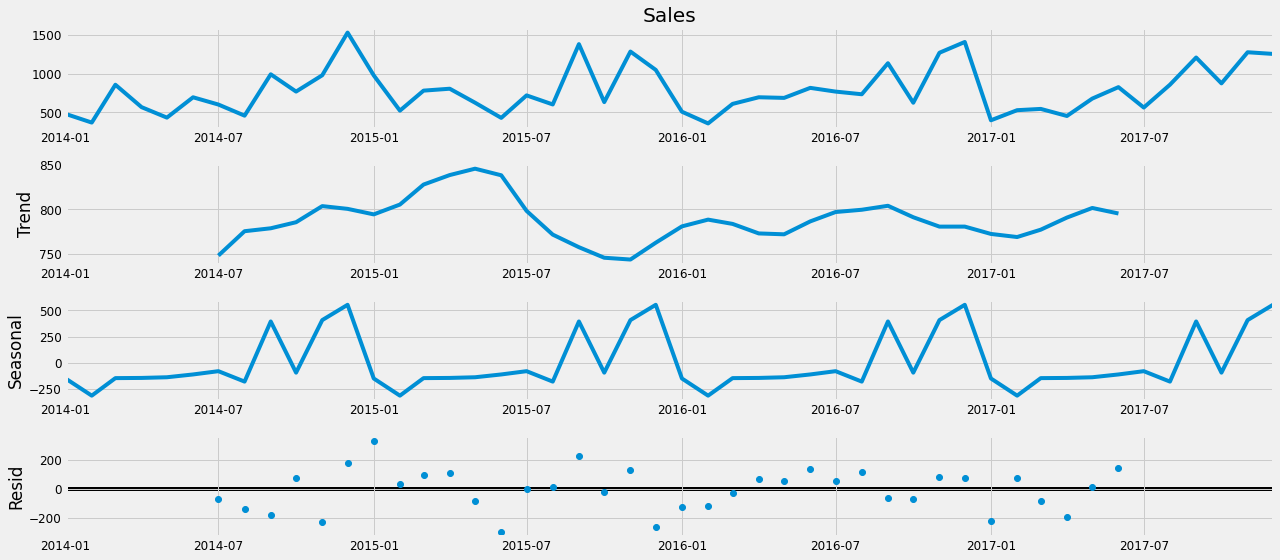

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

# Additive model means that addition of the trend, seasonal and residual component equates to the actual time series model
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

## Time series forecasting with Seasonal ARIMA (SARIMA)

When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest. 

There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. 

### Parameter Selection for SARIMA Time Series Model

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We can now use the triplets of parameters defined above to automate the process of hyperparameter tuning for model selection.

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the `AIC` (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The `AIC` measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger `AIC` score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

The block of code below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.

In [15]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:784.7193402038779
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:751.4067881886906
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:495.37090274829745
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:489.8305340037366
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:691.7786646574998
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:686.6129493907644
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:491.25398194266415
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:491.80959072921013
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:751.063546273446
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:724.1781121274588
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:497.0445558712977
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:491.66407712413496
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:689.6572888642135
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:685.082313539381
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:493.19798657890635
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:493.6293800238767
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:691.6686053888744
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:680.9064169804171
ARIMA(0

The output of our code suggests that `ARIMA(0, 1, 1)x(0, 1, 1, 12)12` yields the lowest AIC value of `482.83`. We should therefore consider this to be the optimal option out of all the model param combinations we have considered.

## Fitting a SARIMA Time Series Model
Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We’ll start by plugging the optimal parameter values into a new SARIMAX model:

In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12))

results = mod.fit()

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data.

We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The `get_prediction()` and `conf_int()` attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

The `dynamic=False` argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

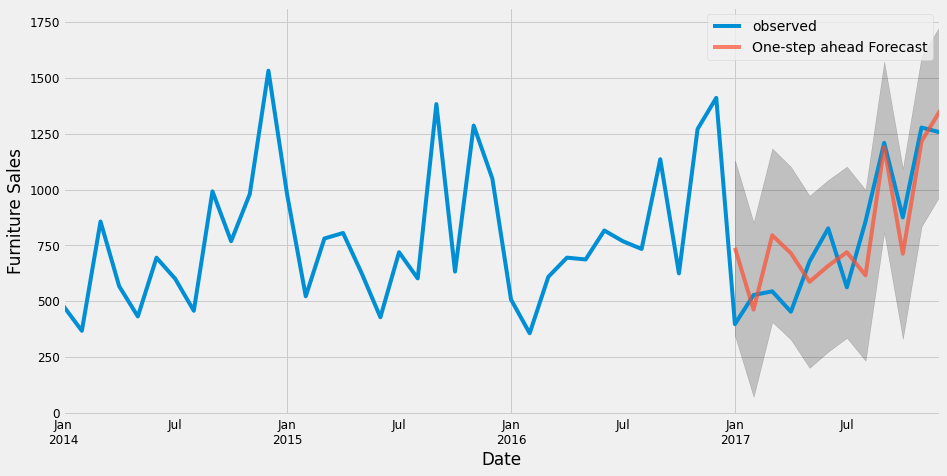

In [17]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values relatively well, showing an upward trend starts from the beginning of the year.

In [18]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 34361.46


In [19]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 185.37


`Mean squared error (MSE)` of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The `MSE` is a measure of the quality of an estimator—it is always non-negative, and the smaller the `MSE`, the closer we are to finding the line of best fit.

`Root Mean Square Error (RMSE)` tells us that our model was able to forecast the average daily furniture sales in the test set within 185.37 of the real sales. Our furniture daily sales range from around 400 to over 1200 which translates into a "decent" RMSE performance.

## Producing and visualizing forecasts

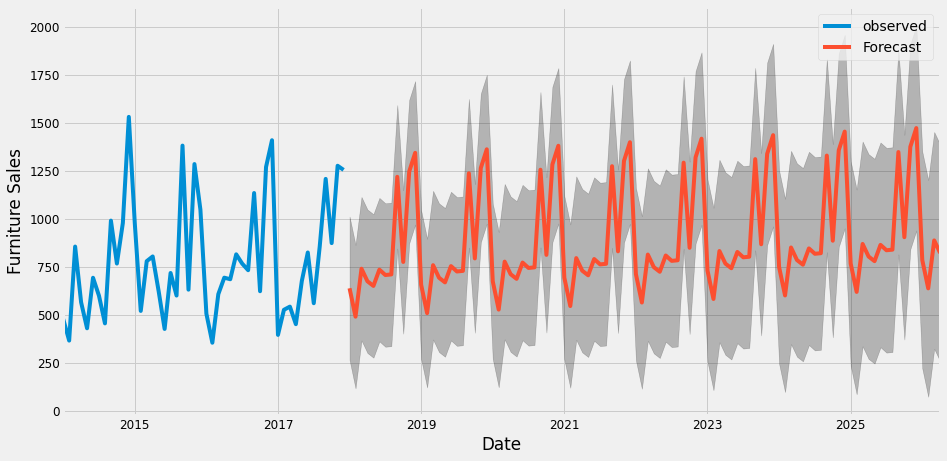

In [20]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture makes us curious about other categories, and how do they compare with each other over time. Therefore, we are going to compare time series of furniture and office supplier.

## Time Series comparison furniture sales and Office Supplies

### Data Preprocessing

In [21]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']

According to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

In [22]:
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [23]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

Have a quick peek, perfect!

In [24]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [25]:
office.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430


### Data exploration

We are going to compare two categories' sales in the same time period. This means combining two data frames into one and plot these two categories' time series into one plot.

In [26]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


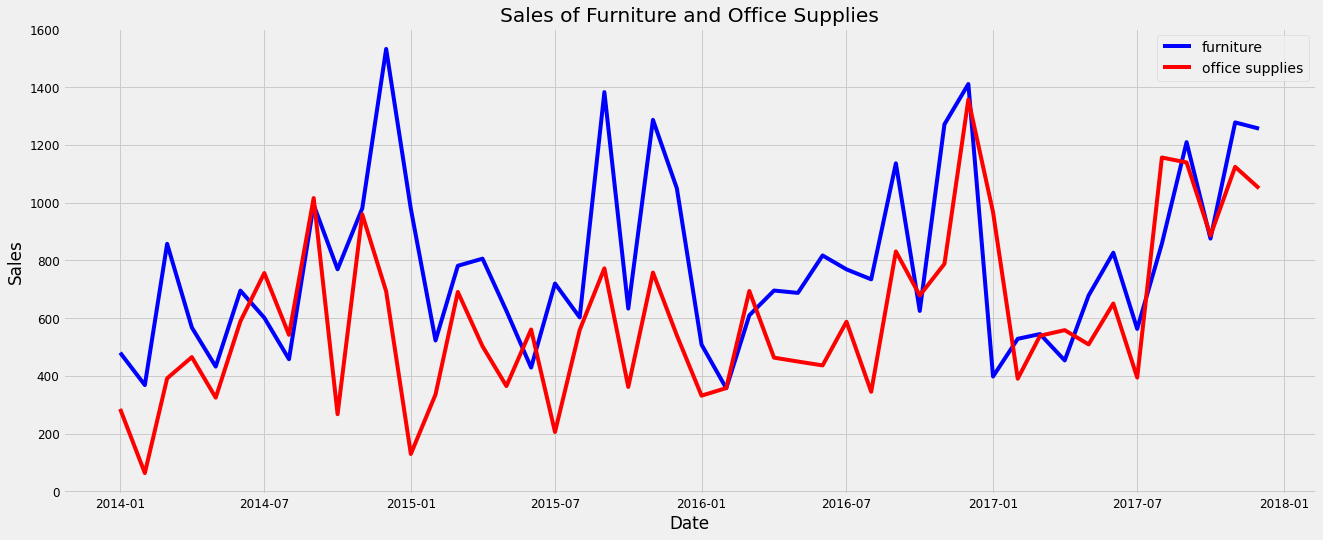

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too. in addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occasionaly, office supplies passed furniture on average daily sales. Let's find out when was the first time office supplies' sales surpassed those of furniture's. 

In [28]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


It was July 2014.

### Here are a few other things you could try:

1. Change the start date of your dynamic forecasts to see how this affects the overall quality of your forecasts.
2. Try more combinations of parameters to see if you can improve the goodness-of-fit of your model.
3. Select a different metric such as Mean Square Error as opposed to AIC to select the best model.